<a href="https://colab.research.google.com/github/eTcilopp/temp_python_intro_course_gb/blob/master/diploma/diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!apt-get install -y pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc texlive-latex-extra
  context wkhtmltopdf librsvg2-bin groff ghc nodejs php python ruby libjs-mathjax libjs-katex
  citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB]


In [62]:
# !jupyter nbconvert --to markdown /content/_diploma.ipynb
!pandoc /content/_diploma.md -o /content/_diploma.docx

Импортируем необходимые библиотеки

In [ ]:
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

Добавим функции для присвоения категориям товарных позиций

In [ ]:
# ABC Analysis - 80% of sales
def assign_abc_category(row):
    if row['Cumulative_Percentage'] <= 80:
        return 'A'
    elif row['Cumulative_Percentage'] <= 95:
        return 'B'
    else:
        return 'C'

In [ ]:
# XYZ Analysis - Coeff_of_Variation
def assign_xyz_category(row):
    if row['Coeff_of_Variation'] <= 10:
        return 'X'
    elif row['Coeff_of_Variation'] <= 50:
        return 'Y'
    else:
        return 'Z'

In [ ]:
# FRM Analysis - Coeff_of_Variation
def assign_frm_category(row):
    if row['Cumulative_Percentage'] <= 50:
        return 'F'
    elif row['Cumulative_Percentage'] <= 80:
        return 'M'
    else:
        return 'R'

Загрузим датасет из файла csv

In [ ]:
df = pd.read_csv("/content/sample_data/scanner_data.csv")

In [ ]:
df.head(2)

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46


Извлечем только интересующие нас данные: <br>
- артикул товарной позиции,<br>
- количество в одной продаже,<br>
- общая цена продажи

In [ ]:
df_sub = df[['SKU', 'Quantity', 'Sales_Amount']]
df_sub.head(2)

,SKU,Quantity,Sales_Amount
0,0EM7L,1.0,3.13
1,68BRQ,1.0,5.46


Добавим столбцы с процентной долей каждой продажи от общего числа проданного,<br>
долю с накопительным итогом,<br>
выполним присвоение ABC - категорий

In [ ]:
df_sub_abc = df_sub.groupby('SKU').sum()
total_sales_amount = df_sub_abc['Sales_Amount'].sum()
df_sub_abc = df_sub_abc.sort_values(by=['Sales_Amount'], ascending=False)
df_sub_abc['Percentage'] = (df_sub_abc['Sales_Amount'] / total_sales_amount) * 100
df_sub_abc['Cumulative_Percentage'] = df_sub_abc['Percentage'].cumsum()
df_sub_abc['ABC_Category'] = df_sub_abc.apply(assign_abc_category, axis=1)
df_sub_abc.reset_index(inplace=True)

Построим график

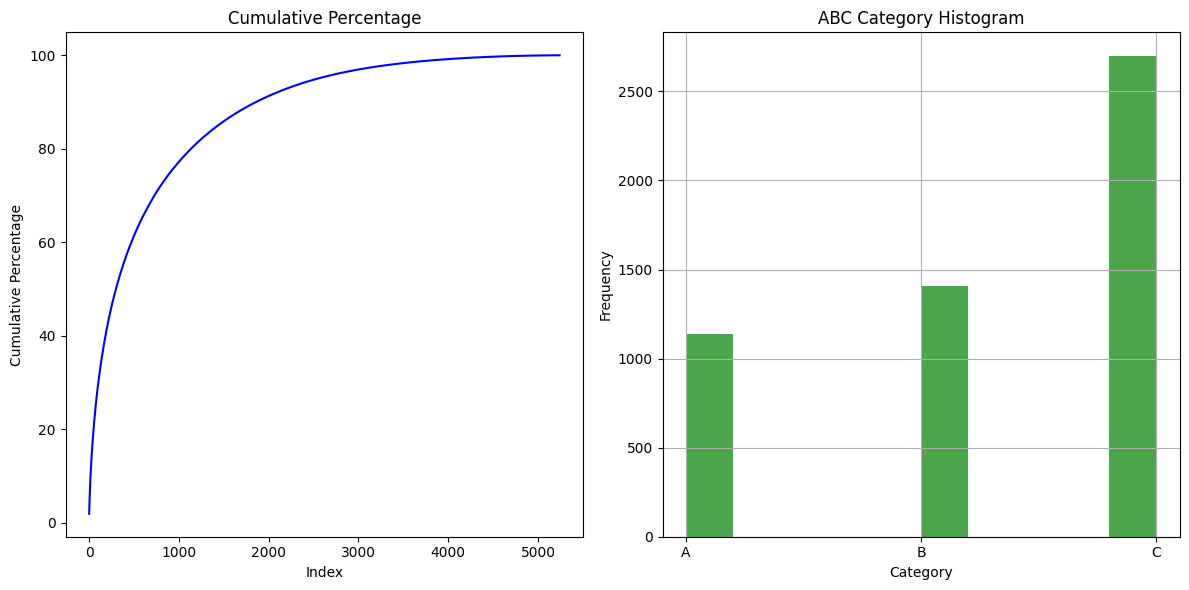

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 grid of subplots

# Plot 1: Line plot of Cumulative_Percentage
df_sub_abc['Cumulative_Percentage'].plot(ax=axes[0], color='blue', title='Cumulative Percentage')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Cumulative Percentage')

# Plot 2: Histogram of ABC_Category
df_sub_abc['ABC_Category'].hist(ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('ABC Category Histogram')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

Форма кривой соответствует принципу Парето:<br>
Меньшаая часть позиций дает большую часть параметра

Проведем расчеты для XYZ-анализа

In [ ]:
grouped_data = df_sub.groupby('SKU')['Quantity']
std_deviation = grouped_data.std()
mean_value = grouped_data.mean()
result = std_deviation / mean_value * 100
result_df = result.reset_index(name='Coeff_of_Variation')
df_sub_xyz = result_df.sort_values(by='Coeff_of_Variation', ascending=True)
df_sub_xyz['XYZ_Category'] = df_sub_xyz.apply(assign_xyz_category, axis=1)

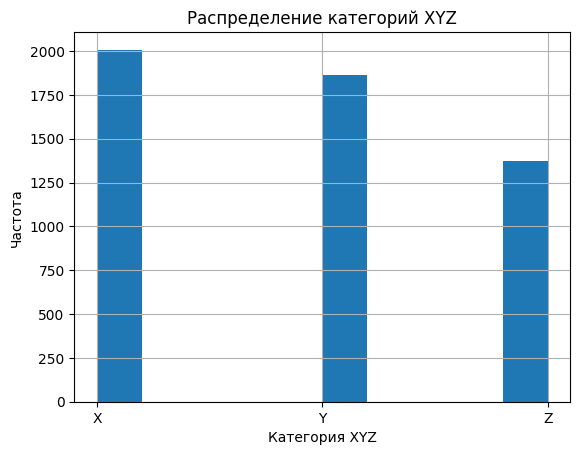

In [ ]:
df_sub_xyz['XYZ_Category'].hist()
plt.title("Распределение категорий XYZ")
plt.xlabel("Категория XYZ")
plt.ylabel("Частота")
plt.show()

Присвоим категории F, M и R: FRM analysis

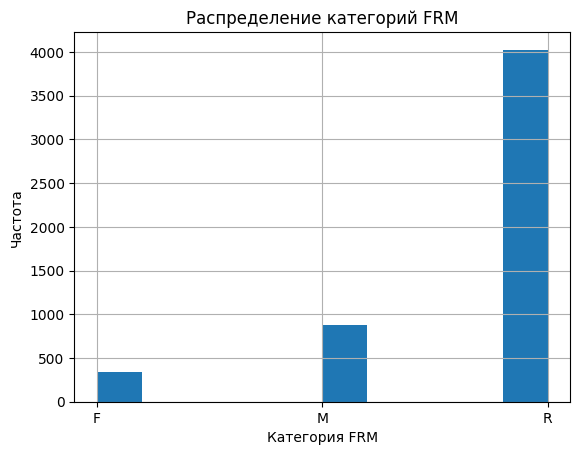

In [ ]:
df_sub_frm = df_sub['SKU'].value_counts().reset_index(name='Order_Count')
df_sub_frm.columns = ['SKU', 'Order_Count']
df_sub_frm = df_sub_frm.sort_values(by=['Order_Count'], ascending=False)
total_number_of_orders = df_sub_frm['Order_Count'].sum()
df_sub_frm['Percentage'] = (df_sub_frm['Order_Count'] / total_number_of_orders) * 100
df_sub_frm['Cumulative_Percentage'] = df_sub_frm['Percentage'].cumsum()
df_sub_frm['FRM_Category'] = df_sub_frm.apply(assign_frm_category, axis=1)
df_sub_frm['FRM_Category'].hist()
plt.title("Распределение категорий FRM")
plt.xlabel("Категория FRM")
plt.ylabel("Частота")
plt.show()

Объединим ABC, XYZ и FRM показателеи в один

In [ ]:
merged_df = pd.merge(df,
                     df_sub_abc.set_index('SKU')[['ABC_Category']], # Set 'SKU' as index in df_sub_abc
                     on='SKU',
                     how='left')

merged_df = pd.merge(merged_df,
                     df_sub_xyz[['SKU', 'XYZ_Category']],
                     on='SKU',
                     how='left')

merged_df = pd.merge(merged_df,
                     df_sub_frm[['SKU', 'FRM_Category']],
                     on='SKU',
                     how='left')

merged_df = merged_df[['Date', 'SKU', 'SKU_Category', 'Quantity', 'Sales_Amount', 'ABC_Category', 'XYZ_Category', 'FRM_Category']]
merged_df['AXF_Category'] = merged_df['ABC_Category'] + merged_df['XYZ_Category'] + merged_df['FRM_Category']

Извлекаем позиции категории AXF:<br>
позиции, приносящие наибольший оборот,<br>
самые стабильные и часто отгружаемые

In [ ]:
category_axf_df = merged_df[merged_df['AXF_Category'] == 'AXF'].copy()

In [ ]:
category_axf_df.head(3)

,Date,SKU,SKU_Category,Quantity,Sales_Amount,ABC_Category,XYZ_Category,FRM_Category,AXF_Category
1,02/01/2016,68BRQ,2ML,1.0,5.46,A,X,F,AXF
6,02/01/2016,AHAE7,XG4,1.0,3.65,A,X,F,AXF
8,02/01/2016,9STQJ,0H2,1.0,8.25,A,X,F,AXF


In [ ]:
category_axf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4716 entries, 1 to 131693
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4716 non-null   object 
 1   SKU           4716 non-null   object 
 2   SKU_Category  4716 non-null   object 
 3   Quantity      4716 non-null   float64
 4   Sales_Amount  4716 non-null   float64
 5   ABC_Category  4716 non-null   object 
 6   XYZ_Category  4716 non-null   object 
 7   FRM_Category  4716 non-null   object 
 8   AXF_Category  4716 non-null   object 
dtypes: float64(2), object(7)
memory usage: 368.4+ KB


Подготовим данные для дальнейшего использования: <br>
Приведем даты к формату М/Д/Г, <br>
переименуем столбец Date в ds, столбец Quantity в y <br>
-- это необходимо для передачи данных в модель Prophet


In [ ]:
category_axf_df['Date'] = pd.to_datetime(category_axf_df['Date'], format='%d/%m/%Y')
category_axf_df['Month_number'] = category_axf_df['Date'].dt.month
category_axf_df = category_axf_df.rename(columns={'Quantity': 'y'})
category_axf_df.head(2)

,Date,SKU,SKU_Category,y,Sales_Amount,ABC_Category,XYZ_Category,FRM_Category,AXF_Category,Month_number
1,2016-01-02,68BRQ,2ML,1.0,5.46,A,X,F,AXF,1
6,2016-01-02,AHAE7,XG4,1.0,3.65,A,X,F,AXF,1


Подготовим список уникадных кодов товарных позици. <br>
Случайным образом выберем 5 позиций для детального изучения

In [ ]:
unique_skus = category_axf_df['SKU'].unique().tolist()
unique_skus = random.sample(unique_skus, 5)
category_axf_df = category_axf_df[category_axf_df['SKU'].isin(unique_skus)].copy()
unique_skus

['ZD3Z4', '536VK', '1MR3E', 'Y6DHV', '0OZBT']

Проанализируем исторические продажи по каждой позиции<br>
и подготовим прогноз продаж на следующий период (месяц)<br>
с помощью моделии ИИ Prophet

In [ ]:
result = {"sku": [], "predicted_sales": []}
for sku in unique_skus:
    sku_df = category_axf_df[category_axf_df['SKU'] == sku].sort_values(by=['Date'], ascending=True)
    sku_df_monthly = sku_df.groupby('Month_number')['y'].sum().reset_index(name='y')
    year = sku_df['Date'].dt.year.max()
    sku_df_monthly['ds'] = sku_df_monthly['Month_number'].apply(lambda x: datetime.strptime(f"{str(x).zfill(2)}/01/{year}", "%m/%d/%Y"))

    ml_df = sku_df_monthly[['ds', 'y']]

    model = Prophet()
    model.fit(ml_df)

    future = model.make_future_dataframe(periods=1)

    forecast = model.predict(future)
    forecast_only = forecast[forecast['ds'] > ml_df['ds'].max()]
    sum_yhat = forecast_only['yhat'].sum()
    result["sku"].append(sku)
    result["predicted_sales"].append(sum_yhat)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqddfck0/8i_luxpv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqddfck0/5jsviy4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27439', 'data', 'file=/tmp/tmpcqddfck0/8i_luxpv.json', 'init=/tmp/tmpcqddfck0/5jsviy4l.json', 'output', 'file=/tmp/tmpcqddfck0/prophet_model7hfq0aby/prophet_model-20240918134928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:49:28 - cmdstanpy - INFO - Chain [1] start processing
IN

Получаем прогнозы продаж на следующий период (месяц)

In [ ]:
result_df = pd.DataFrame(result).map(lambda x: np.ceil(x) if isinstance(x, (int, float)) else x)
result_df

,sku,predicted_sales
0,ZD3Z4,9.0
1,536VK,45.0
2,1MR3E,17.0
3,Y6DHV,17.0
4,0OZBT,15.0


# Тестирование модели
Примем данные первые полгода в качестве учебного датасета<br>
и выполним расчет прогноза продаж на следующий месяц<br>
После этого возьмем реальные данные за 7 месяцев,<br>
и выполни расчет прогноза прода на месяц 8
Таким образом, мы получим данные о предсказанных продажах<br>
на следующие полгода и сможем увидеть, насколько прогнозы хороши.

In [ ]:
START_PERIOD_NUM = 7
END_PERIOD_NUM = 12

Создаем пустой датасет, в котором будем хранить прогнозы  для каждой позиции

In [ ]:
predicted_sales_df = pd.DataFrame()
predicted_sales_df_columns = [
    'ds',
    'SKU',
    'SKU_Category',
    'y',
    'Sales_Amount',
    'Month_number',
    'Predicted_monthly_sales'
 ]
predicted_sales_df = pd.DataFrame(columns=predicted_sales_df_columns)

Выполним код, чтобы получить прогноз продаж для каждой позиции<br>
на следующий месяц для каждого из месяцов начиная с 7-го

In [ ]:
for period in range(START_PERIOD_NUM, END_PERIOD_NUM):
  for sku in unique_skus:
    sku_df = category_axf_df[category_axf_df['SKU'] == sku].sort_values(by=['Date'], ascending=True)
    year = sku_df['Date'].dt.year.max()
    sku_df_monthly = sku_df.groupby('Month_number')['y'].sum().reset_index(name='y')
    training_df = sku_df_monthly[sku_df_monthly['Month_number'] < period].copy()
    training_df['ds'] = training_df['Month_number'].apply(lambda x: datetime.strptime(f"{str(x).zfill(2)}/01/{year}", "%m/%d/%Y"))
    training_df = training_df[training_df['Month_number'] < period]


    model = Prophet()
    ml_df = training_df[['ds', 'y']]
    if len(ml_df) < 3:
      continue
    model.fit(ml_df[['ds', 'y']])

    future = model.make_future_dataframe(periods=1)
    forecast = model.predict(future)
    forecast_only = forecast[forecast['ds'] > ml_df['ds'].max()]
    order_size = int(forecast_only['yhat'].sum())
    if order_size < 0:
        order_size = 0

    order_refill_date = datetime.strptime(f"{str(period + 1).zfill(2)}/01/{year}", "%m/%d/%Y")

    predicted_sales_data = dict(zip(predicted_sales_df, [order_refill_date, sku, sku_df.head(1)['SKU_Category'].values[0], 0, 0, period + 1, order_size]))
    new_row = pd.DataFrame([predicted_sales_data])

    predicted_sales_df = pd.concat([predicted_sales_df, new_row], ignore_index=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqddfck0/bxuvfc7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcqddfck0/19bhxuie.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25620', 'data', 'file=/tmp/tmpcqddfck0/bxuvfc7h.json', 'init=/tmp/tmpcqddfck0/19bhxuie.json', 'output', 'file=/tmp/tmpcqddfck0/prophet_model792bj2yn/prophet_model-20240918135457.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:54:57 - cmdstanpy - INFO - Chain [1] start processing
IN

Получаем датасет с прогнозами

In [ ]:
predicted_sales_df.head(5)

,ds,SKU,SKU_Category,y,Sales_Amount,Month_number,Predicted_monthly_sales
0,2016-08-01,ZD3Z4,F9B,0,0,8,7
1,2016-08-01,536VK,QCG,0,0,8,37
2,2016-08-01,1MR3E,P42,0,0,8,11
3,2016-08-01,Y6DHV,H15,0,0,8,6
4,2016-08-01,0OZBT,OXH,0,0,8,14


Объединим датасет прогнозов с датасетом реальных продаж

In [ ]:
category_axf_df.drop(columns=['Sales_Amount', 'ABC_Category', 'XYZ_Category', 'FRM_Category', 'AXF_Category'], inplace=True)
predicted_sales_df.drop(columns=['Sales_Amount'], inplace=True)
predicted_sales_df.rename(columns={'ds': 'Date'}, inplace=True)

combined_df = pd.concat([predicted_sales_df, category_axf_df], ignore_index=True)
combined_df.rename(columns={'y': 'Actual_sales'}, inplace=True)
combined_df.fillna(0, inplace=True)
combined_df.head(2)

,Date,SKU,SKU_Category,Actual_sales,Month_number,Predicted_monthly_sales
0,2016-08-01,ZD3Z4,F9B,0,8,7
1,2016-08-01,536VK,QCG,0,8,37


Добавим датасет с рассчитанными складскими остатками

In [ ]:
combined_df_with_stock_level = pd.DataFrame()
combined_df_with_stock_level_columns = [
    'Date',
    'SKU',
    'SKU_Category',
    'Actual_sales',
    'Month_number',
    'Predicted_monthly_sales',
    'Replenishment_order',
    'Stock_level'
 ]
combined_df_with_stock_level = pd.DataFrame(columns=combined_df_with_stock_level_columns)

Выполним расчет прогнозируемых складских остатков для каждой позиции<br>
с учетом реальных продаж и рассчетного размера заказа на пополнение запаса

In [ ]:
for period in range(START_PERIOD_NUM, END_PERIOD_NUM):
  for sku in unique_skus:
    sku_df = combined_df[(combined_df['SKU'] == sku) & (combined_df['Month_number'] > START_PERIOD_NUM)].sort_values(by='Date', ascending=True)
    stock_level = 0
    for index, row in sku_df.iterrows():
      stock_level -= row['Actual_sales']
      if stock_level < 0:
        stock_level = 0
      if row['Predicted_monthly_sales'] > 0:
        replenishment_order = row['Predicted_monthly_sales'] - stock_level
        stock_level += replenishment_order
        sku_df.at[index, 'Stock_level'] = stock_level
        sku_df.at[index, 'Replenishment_order'] = replenishment_order
      else:
        sku_df.at[index, 'Stock_level'] = stock_level
        sku_df.at[index, 'Replenishment_order'] = 0

    combined_df_with_stock_level = pd.concat([combined_df_with_stock_level, sku_df], ignore_index=True)
    combined_df_with_stock_level[(combined_df_with_stock_level['SKU'] == sku) & (combined_df_with_stock_level['Month_number'] >= START_PERIOD_NUM)].sort_values(by='Date', ascending=True)

<ipython-input-37-514eb824980e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df_with_stock_level = pd.concat([combined_df_with_stock_level, sku_df], ignore_index=True)


Построим графики изменения уровня остатков.<br>
Наблюдаем классическую "пилу" уровня запасов<br>
Можно видеть, где запаса оказалось недостаточно<br>
(плоские участки внизу)

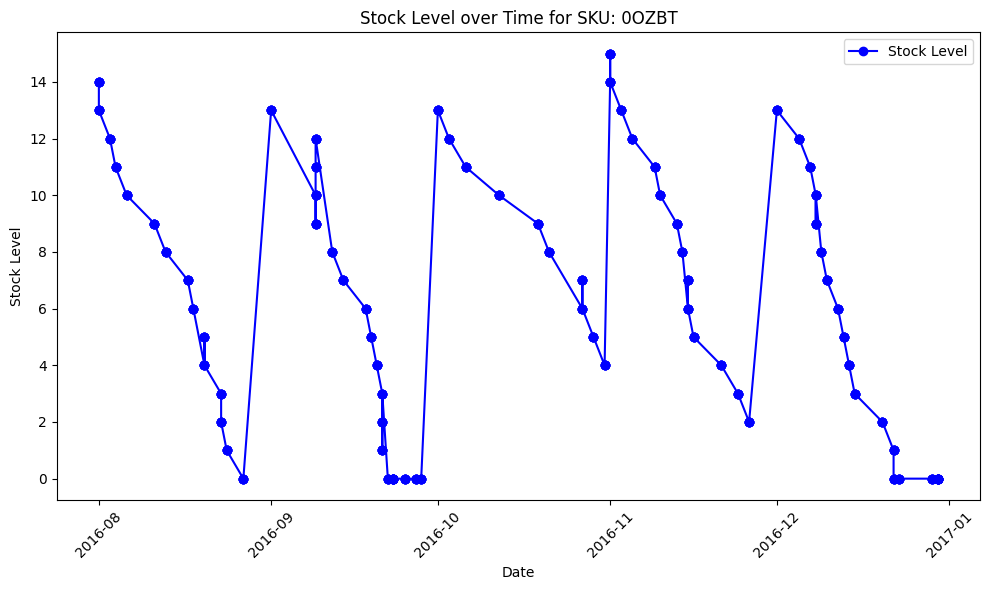

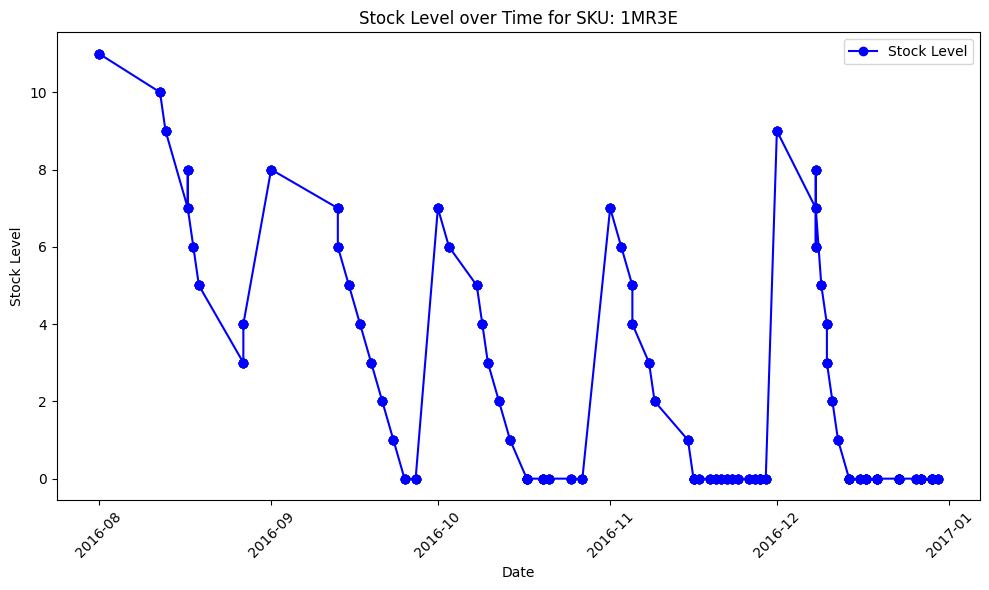

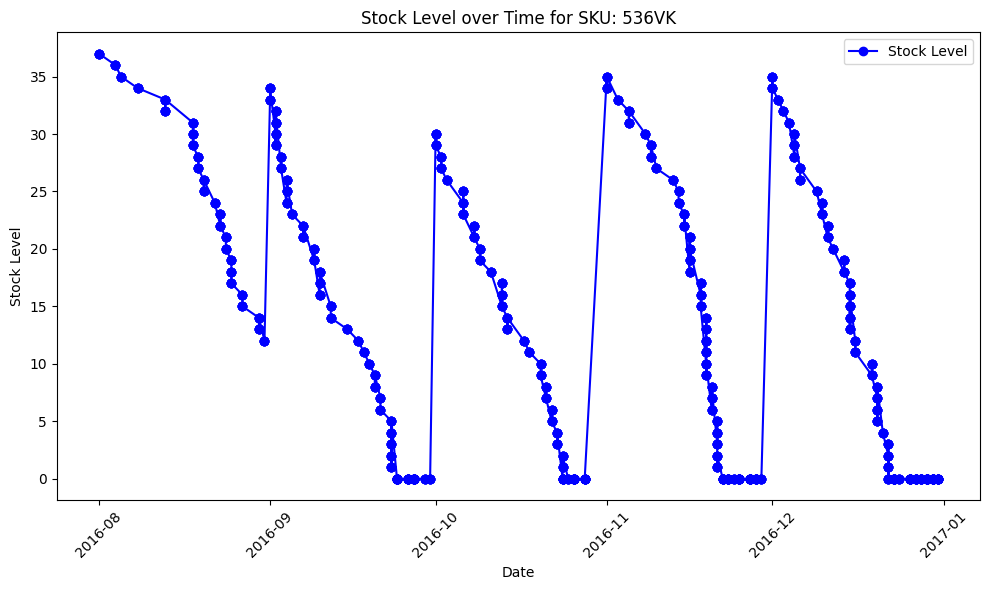

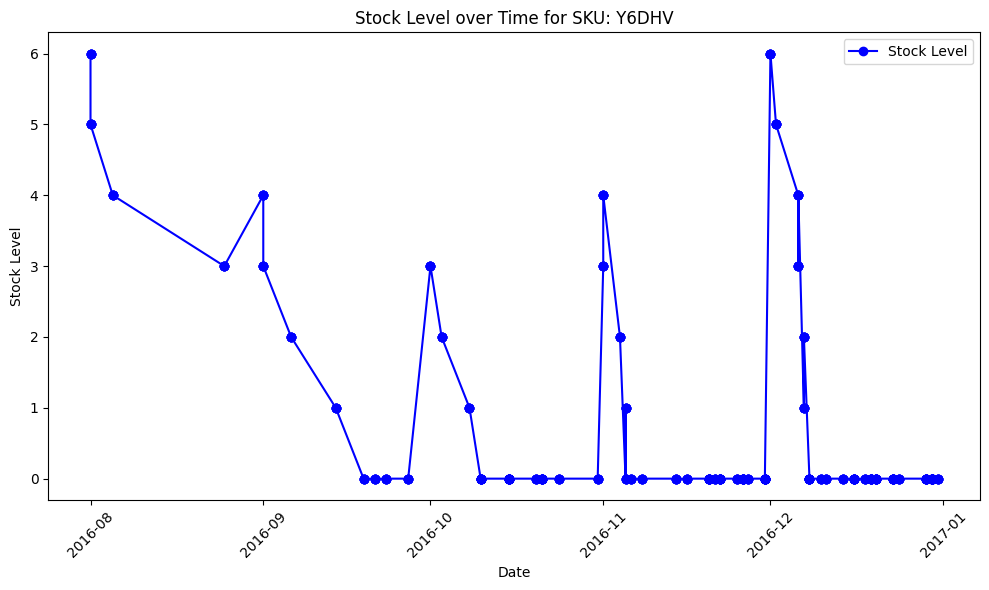

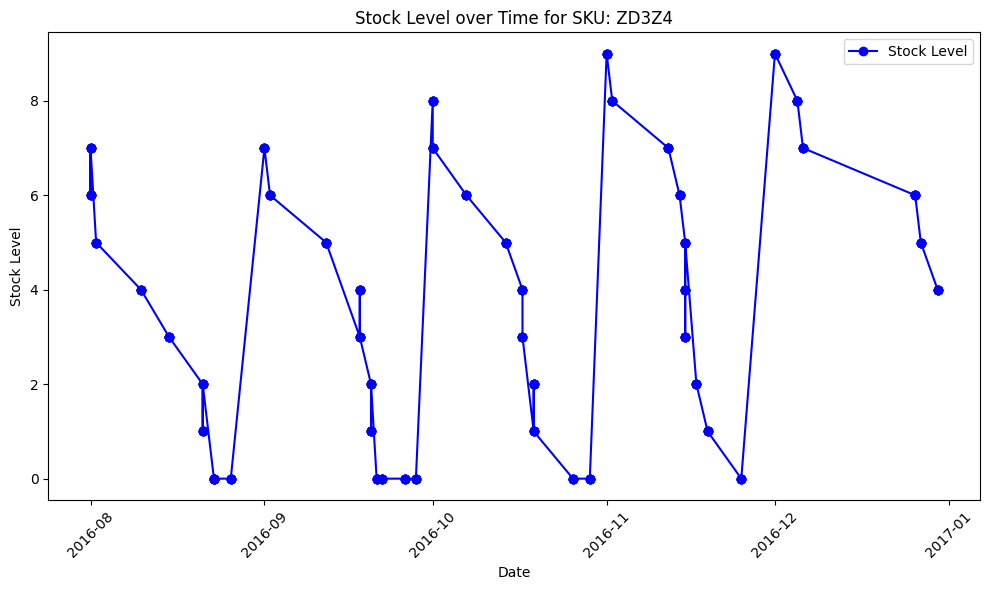

In [ ]:
grouped = combined_df_with_stock_level.groupby('SKU')

for sku, sub_df in grouped:
    sub_df_sorted = sub_df.sort_values(by='Date', ascending=True)

    plt.figure(figsize=(10, 6))

    plt.plot(sub_df_sorted['Date'], sub_df_sorted['Stock_level'], marker='o', color='blue', label='Stock Level')

    plt.xlabel('Date')
    plt.ylabel('Stock Level')
    plt.title(f'Stock Level over Time for SKU: {sku}')
    plt.legend()

    plt.xticks(rotation=45)

    plt.tight_layout()

    plt.show()


#Теперь выполним расчет с помощью формулы страхового запаса
Имеем тот же набор позиций AXF


In [ ]:
category_axf_df.head(1)

,Date,SKU,SKU_Category,y,Month_number
79,2016-01-02,5FESW,C8Z,1.0,1


Создаем пустой датасет для прогнозов продаж

In [ ]:
predicted_sales_df_ss = pd.DataFrame()
predicted_sales_df_columns = [
    'ds',
    'SKU',
    'SKU_Category',
    'y',
    'Sales_Amount',
    'Month_number',
    'Predicted_monthly_sales'
 ]
predicted_sales_df_ss = pd.DataFrame(columns=predicted_sales_df_columns)

Выполняем расчет размера страхового товарного запаса,<br>
покрывающего потребности с вероятностью 99%

In [ ]:
for period in range(START_PERIOD_NUM, END_PERIOD_NUM):
    for sku in unique_skus:
      sku_df = category_axf_df[category_axf_df['SKU'] == sku].sort_values(by=['Date'], ascending=True)
      year = sku_df['Date'].dt.year.max()

      training_df = sku_df[sku_df['Month_number'] < period].copy()

      average_sales_per_day = training_df['y'].sum() / (30 * len(training_df))
      montly_std_deviation = training_df.groupby('Month_number')['y'].sum().std()
      stock_safety_coeff = 2.33 # 95%  2.33 99%
      order_size = np.ceil(average_sales_per_day + stock_safety_coeff * montly_std_deviation)
      if order_size < 0:
          order_size = 0
      order_refill_date = datetime.strptime(f"{str(period + 1).zfill(2)}/01/{year}", "%m/%d/%Y")
      predicted_sales_data = dict(zip(predicted_sales_df_ss, [order_refill_date, sku, sku_df.head(1)['SKU_Category'].values[0], 0, 0, period + 1, order_size]))
      new_row = pd.DataFrame([predicted_sales_data])

      predicted_sales_df_ss = pd.concat([predicted_sales_df_ss, new_row], ignore_index=True)

<ipython-input-42-3bbba3f84a0c>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_sales_df_ss = pd.concat([predicted_sales_df_ss, new_row], ignore_index=True)


Получаем прогнозы продаж на следующие полгода, объединенные с данными о продажах

In [ ]:
predicted_sales_df_ss.drop(columns=['Sales_Amount'], inplace=True)
predicted_sales_df_ss.rename(columns={'ds': 'Date'}, inplace=True)

combined_df_ss = pd.concat([predicted_sales_df_ss, category_axf_df], ignore_index=True)
combined_df_ss.rename(columns={'y': 'Actual_sales'}, inplace=True)
combined_df_ss.fillna(0, inplace=True)
combined_df_ss.head(5)

,Date,SKU,SKU_Category,Actual_sales,Month_number,Predicted_monthly_sales
0,2016-08-01,ZD3Z4,F9B,0,8,6.0
1,2016-08-01,536VK,QCG,0,8,15.0
2,2016-08-01,1MR3E,P42,0,8,9.0
3,2016-08-01,Y6DHV,H15,0,8,13.0
4,2016-08-01,0OZBT,OXH,0,8,7.0


Выполним расчет прогнозируемых складских остатков для каждой позиции<br>
с учетом реальных продаж и рассчетного размера заказа на пополнение запаса

In [ ]:
combined_df_with_stock_level_ss = pd.DataFrame()
combined_df_with_stock_level_columns = [
    'Date',
    'SKU',
    'SKU_Category',
    'Actual_sales',
    'Month_number',
    'Predicted_monthly_sales',
    'Replenishment_order',
    'Stock_level'
 ]
combined_df_with_stock_level_ss = pd.DataFrame(columns=combined_df_with_stock_level_columns)

In [ ]:
for period in range(START_PERIOD_NUM, END_PERIOD_NUM):
  for sku in unique_skus:
    sku_df = combined_df_ss[(combined_df_ss['SKU'] == sku) & (combined_df_ss['Month_number'] > START_PERIOD_NUM)].sort_values(by='Date', ascending=True)
    stock_level = 0
    for index, row in sku_df.iterrows():
      stock_level -= row['Actual_sales']
      if stock_level < 0:
        stock_level = 0
      if row['Predicted_monthly_sales'] > 0:
        replenishment_order = row['Predicted_monthly_sales'] - stock_level
        stock_level += replenishment_order
        sku_df.at[index, 'Stock_level'] = stock_level
        sku_df.at[index, 'Replenishment_order'] = replenishment_order
      else:
        sku_df.at[index, 'Stock_level'] = stock_level
        sku_df.at[index, 'Replenishment_order'] = 0

    combined_df_with_stock_level_ss = pd.concat([combined_df_with_stock_level_ss, sku_df], ignore_index=True)

<ipython-input-45-ef8bc223fd49>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df_with_stock_level_ss = pd.concat([combined_df_with_stock_level_ss, sku_df], ignore_index=True)


In [ ]:
combined_df_with_stock_level_ss.head(3)

,Date,SKU,SKU_Category,Actual_sales,Month_number,Predicted_monthly_sales,Replenishment_order,Stock_level
0,2016-08-01,ZD3Z4,F9B,0,8,6.0,6.0,6.0
1,2016-08-01,ZD3Z4,F9B,1.0,8,0.0,0.0,5.0
2,2016-08-02,ZD3Z4,F9B,1.0,8,0.0,0.0,4.0


Построим графики изменения остатков

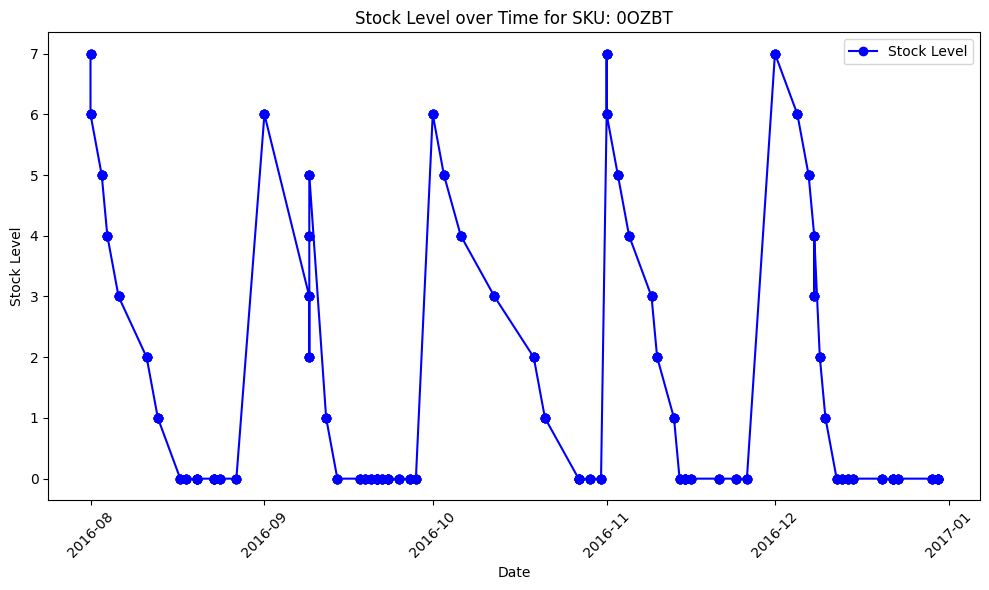

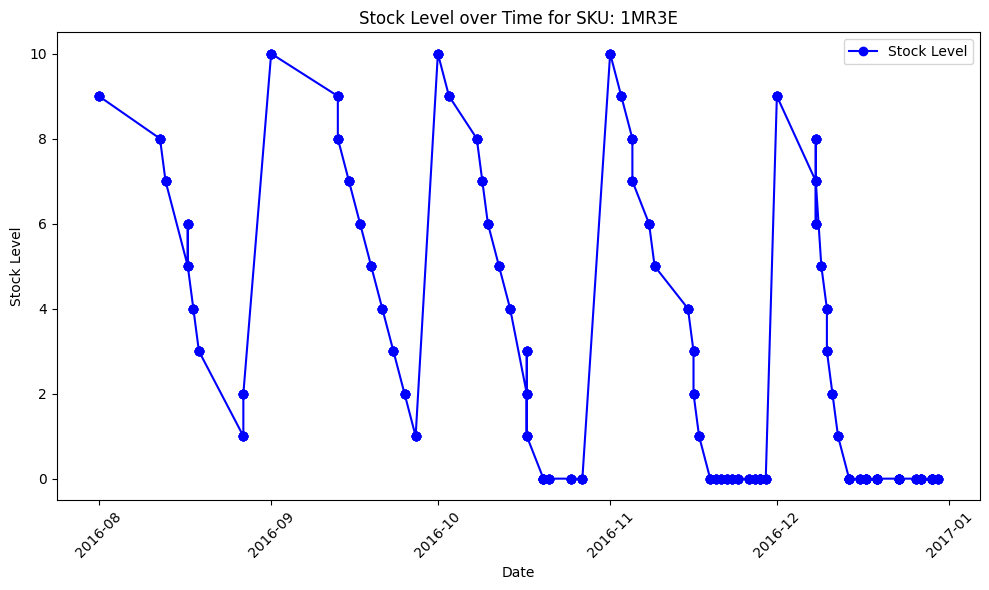

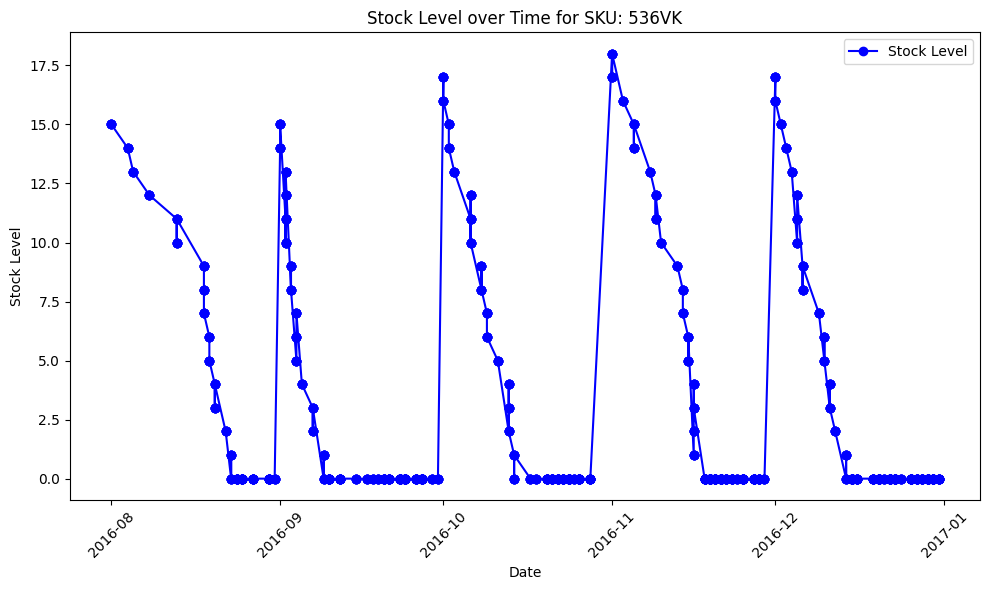

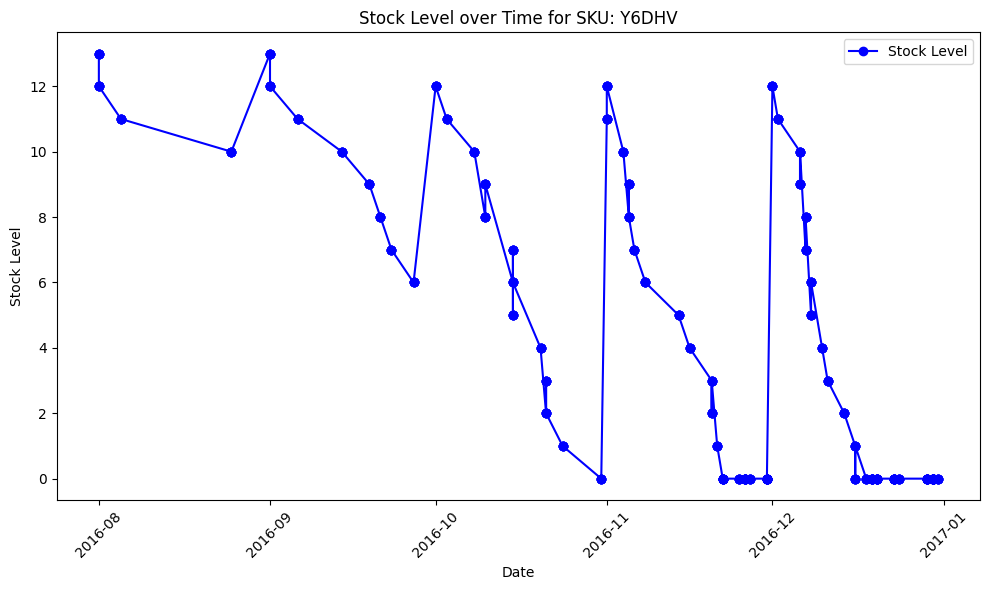

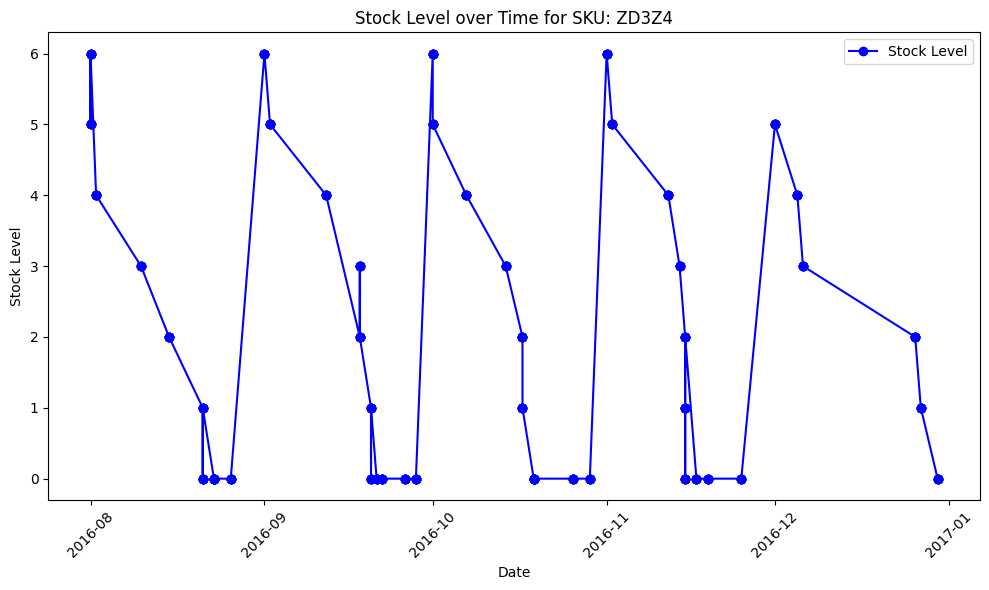

In [ ]:
grouped = combined_df_with_stock_level_ss.groupby('SKU')

for sku, sub_df in grouped:
    # Sort the DataFrame by the 'ds' column
    sub_df_sorted = sub_df.sort_values(by='Date', ascending=True)

    # Create a new figure for each SKU
    plt.figure(figsize=(10, 6))

    # Plot the stock levels for all values in one plot
    plt.plot(sub_df_sorted['Date'], sub_df_sorted['Stock_level'], marker='o', color='blue', label='Stock Level')

    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Stock Level')
    plt.title(f'Stock Level over Time for SKU: {sku}')
    plt.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


Теперь наложим графики один на другой,чтобы сравнить качество прогнозов

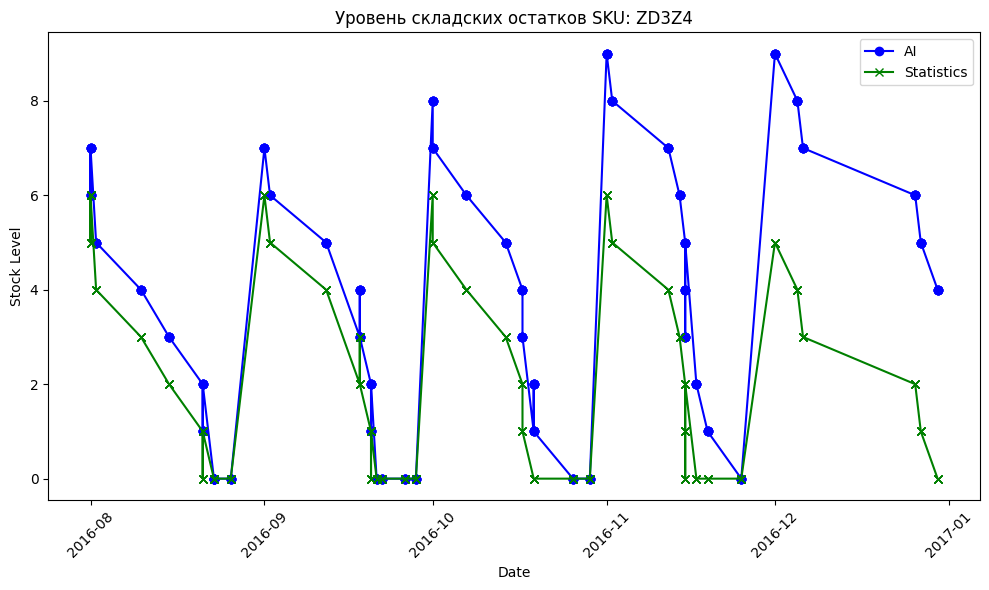

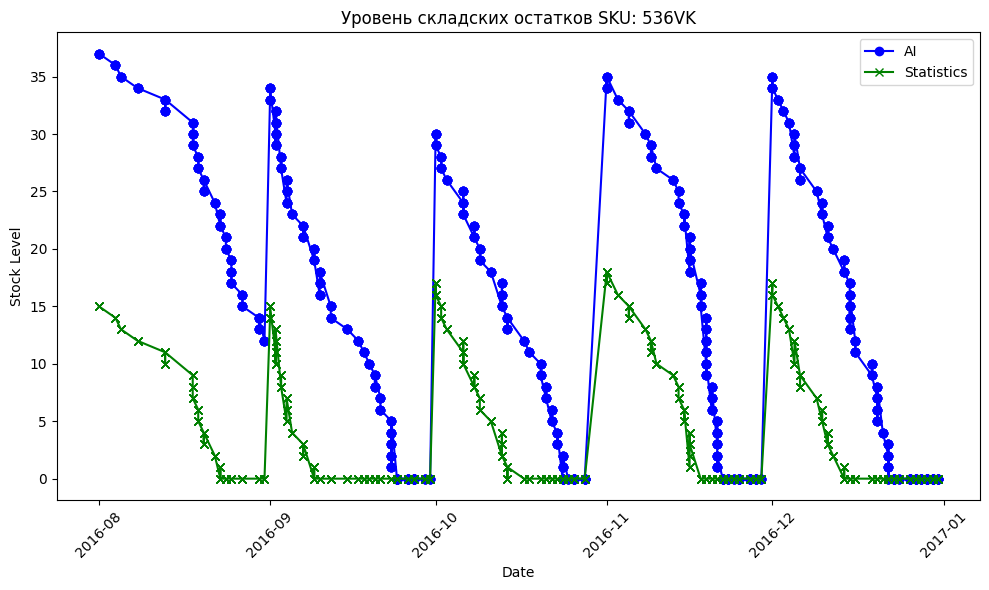

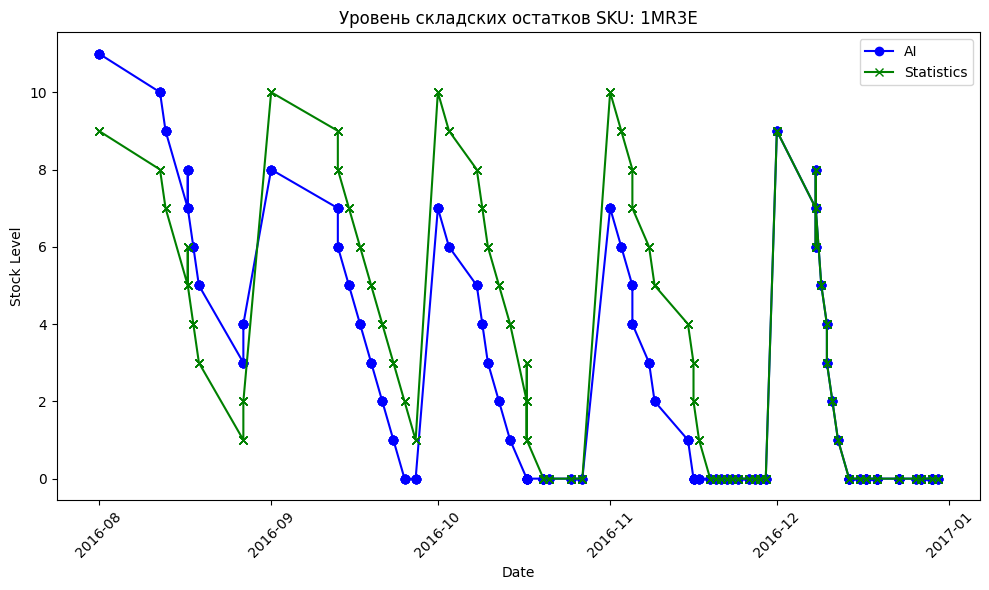

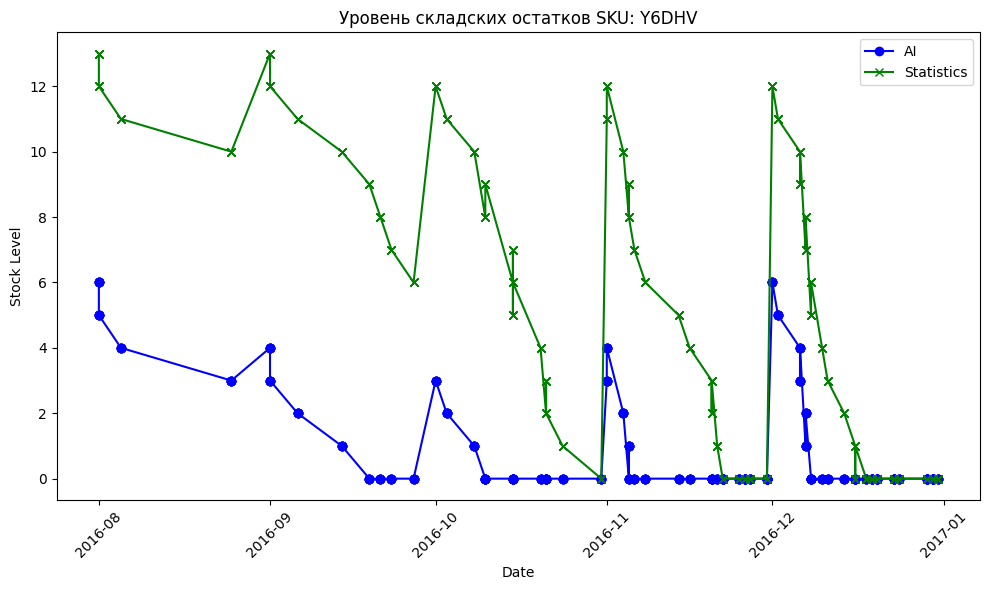

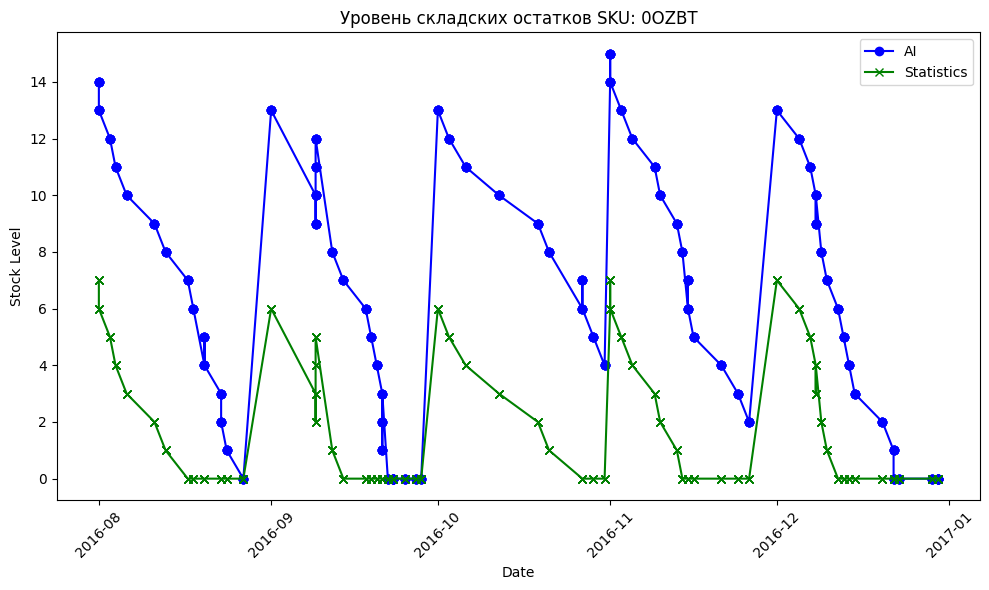

In [ ]:
import matplotlib.pyplot as plt

def plot_stock_levels(df1, label_df1, df2, label_df2):
    # Get unique SKUs
    unique_skus = df1['SKU'].unique()

    # Iterate over each SKU
    for sku in unique_skus:
        # Filter data for the current SKU from both dataframes
        df1_sku = df1[df1['SKU'] == sku].sort_values(by='Date', ascending=True)
        df2_sku = df2[df2['SKU'] == sku].sort_values(by='Date', ascending=True)

        # Plot the Stock_level for df1
        plt.figure(figsize=(10, 6))
        plt.plot(df1_sku['Date'], df1_sku['Stock_level'], label=label_df1, color='blue', marker='o')

        # Plot the Stock_level for df2
        plt.plot(df2_sku['Date'], df2_sku['Stock_level'], label=label_df2, color='green', marker='x')

        # Add title and labels
        plt.title(f'Уровень складских остатков SKU: {sku}')
        plt.xlabel('Date')
        plt.ylabel('Stock Level')

        # Show legend
        plt.legend()

        # Show the plot
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage
plot_stock_levels(combined_df_with_stock_level, 'AI', combined_df_with_stock_level_ss, 'Statistics')
